# Data Cleaning and Corruption Risk Labeling

As established in the theoretical framework, corruption thrives in environments with limited accountability, weak enforcement systems, and institutional weaknesses in governance structures. The UNDP identifies that corruption is fundamentally a governance issue rooted in structural weaknesses.

This notebook operationalizes these theoretical concepts by transforming raw governance and economic indicators into a labeled dataset suitable for machine learning. We apply a threshold-based labeling approach using six World Bank governance indicators that directly measure the structural conditions identified in the literature: voice and accountability, political stability, government effectiveness, regulatory quality, rule of law, and control of corruption.

The labeling methodology is validated against two documented case studies: Malaysia's 1MDB scandal (2013-2015) and Mozambique's hidden debt crisis (2013-2016), both of which involved the diversion of development funds through weak governance structures.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# set working directory to project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 50)

## Data Loading and Initial Assessment

In [20]:
df = pd.read_csv('data/raw/corruption_data_baseline.csv')
print(f"Dataset: {df.shape[0]} observations, {df.shape[1]} variables")
print(f"Countries: {', '.join(df['Country'].unique())}")
print(f"Time period: {df['Year'].min()}-{df['Year'].max()}")
df.head()

Dataset: 45 observations, 13 variables
Countries: Canada, Malaysia, Mozambique
Time period: 2010-2024


,Country,Year,Voice_Accountability,Political_Stability,Government_Effectiveness,Regulatory_Quality,Rule_of_Law,Control_of_Corruption,External_Debt_perc_GNI,GDP_Growth_annual_perc,Govt_Expenditure_perc_GDP,FDI_Inflows_perc_GDP,Poverty_Headcount_Ratio
0,Canada,2010,1.352659,0.936318,1.777827,1.693430,1.798590,2.061873,NaN,3.090806,19.084707,1.837256,0.2
1,Canada,2011,1.380145,1.077176,1.772545,1.684840,1.727120,1.971133,NaN,3.137194,17.850268,2.137833,0.2
2,Canada,2012,1.437505,1.113016,1.756970,1.707195,1.756421,1.918904,NaN,1.755661,17.517520,2.700169,0.2
3,Canada,2013,1.453440,1.061422,1.780741,1.729891,1.747508,1.879378,NaN,2.325814,17.084882,3.629804,0.5
4,Canada,2014,1.412332,1.175504,1.753718,1.838725,1.886297,1.832193,NaN,2.873467,16.402050,3.553903,0.2


In [21]:
# verify governance indicators are present and numeric
governance_cols = ['Voice_Accountability', 'Political_Stability', 'Government_Effectiveness', 
                   'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption']
print("Governance indicators present:", all(col in df.columns for col in governance_cols))

Governance indicators present: True


In [22]:
# assess missing data patterns
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df)) * 100
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print("Variables with missing values:")
print(missing_summary)

Variables with missing values:
                           Missing_Count  Missing_Percent
External_Debt_perc_GNI                31        68.888889
Poverty_Headcount_Ratio               25        55.555556
Govt_Expenditure_perc_GDP              7        15.555556
Voice_Accountability                   3         6.666667
Political_Stability                    3         6.666667
Government_Effectiveness               3         6.666667
Regulatory_Quality                     3         6.666667
Rule_of_Law                            3         6.666667
Control_of_Corruption                  3         6.666667


## Temporal Scope Adjustment

Governance indicators for 2024 are incomplete in the World Bank dataset. Since our labeling methodology depends entirely on these governance measures, we exclude 2024 from the analysis.

In [23]:
df = df[df['Year'] != 2024].copy()
print(f"Final dataset: {df.shape[0]} observations")
print(f"Analysis period: {df['Year'].min()}-{df['Year'].max()}")

Final dataset: 42 observations
Analysis period: 2010-2023


## Missing Data Handling

Governance indicators are required for risk labeling. Economic indicators, while important for model features, can tolerate limited missingness through imputation.

In [24]:
# verify governance indicators are complete
missing_governance = df[governance_cols].isnull().any(axis=1)
print(f"Observations with missing governance indicators: {missing_governance.sum()}")
assert missing_governance.sum() == 0, "All governance indicators must be present for labeling"

Observations with missing governance indicators: 0


In [25]:
# impute missing economic indicators using forward fill within countries
# assumes gradual year-over-year changes in economic indicators
economic_cols = ['External_Debt_perc_GNI', 'GDP_Growth_annual_perc', 
                 'Govt_Expenditure_perc_GDP', 'FDI_Inflows_perc_GDP', 'Poverty_Headcount_Ratio']

for col in economic_cols:
    df[col] = df.groupby('Country')[col].ffill()

print("Remaining missing values in economic indicators:")
print(df[economic_cols].isnull().sum()[df[economic_cols].isnull().sum() > 0])

Remaining missing values in economic indicators:
External_Debt_perc_GNI     28
Poverty_Headcount_Ratio     5
dtype: int64


## Corruption Risk Labeling Methodology

The labeling approach operationalizes the theoretical framework's emphasis on governance structures as indicators of corruption vulnerability. We apply threshold-based flags to six World Bank governance indicators that directly measure the structural weaknesses identified in the literature:

1. **Voice & Accountability** (< 1.15): Measures extent of democratic participation and freedom of expression
2. **Political Stability** (< 0.50): Assesses likelihood of government destabilization
3. **Government Effectiveness** (< 1.15): Evaluates quality of public services and policy implementation
4. **Regulatory Quality** (< 1.15): Measures ability to formulate and implement sound policies
5. **Rule of Law** (< 1.15): Assesses extent to which agents have confidence in and abide by rules
6. **Control of Corruption** (< 1.15): Directly measures perceptions of corruption control

Thresholds are set based on empirical distributions and validated against documented corruption cases. A country-year observation is labeled as **high risk (1)** if it flags on 4 or more indicators, reflecting the multi-dimensional nature of governance failure identified in the theoretical framework. Otherwise, it is labeled as **low risk (0)**.

In [26]:
# define governance thresholds based on empirical analysis
thresholds = {
    'Voice_Accountability': 1.15,
    'Political_Stability': 0.50,
    'Government_Effectiveness': 1.15,
    'Regulatory_Quality': 1.15,
    'Rule_of_Law': 1.15,
    'Control_of_Corruption': 1.15
}

# create binary flags for each governance indicator
for indicator, threshold in thresholds.items():
    df[f'{indicator}_flag'] = (df[indicator] < threshold).astype(int)

# aggregate flags to create risk score
flag_cols = [f'{ind}_flag' for ind in thresholds.keys()]
df['total_flags'] = df[flag_cols].sum(axis=1)

# binary risk label: 4+ flags indicates high corruption risk
df['corruption_risk'] = (df['total_flags'] >= 4).astype(int)

print("Label distribution:")
print(df['corruption_risk'].value_counts().sort_index())
print(f"\nHigh risk proportion: {df['corruption_risk'].mean():.1%}")

Label distribution:
corruption_risk
0    14
1    28
Name: count, dtype: int64

High risk proportion: 66.7%


## Validation Against Documented Corruption Cases

The labeling methodology is validated against two well-documented corruption cases that align with the theoretical framework's emphasis on governance failures enabling fund diversion:

1. **Malaysia (2013-2015)**: The 1MDB scandal involved the theft of $4.5 billion USD from a state development fund, with funds diverted through weak oversight structures (The Guardian, 2020; US Department of Justice, 2024).

2. **Mozambique (2013-2016)**: The hidden debt crisis involved $2 billion USD in illicit loans diverted from development purposes, facilitated by governance weaknesses (CHR Michelsen Institute, 2021; U.S. Department of Justice, 2024).

3. **Canada**: Serves as a control case with strong governance institutions and no documented major corruption scandals during this period.

In [27]:
# validate malaysia 1mdb period (2013-2015)
malaysia_scandal = df[(df['Country'] == 'Malaysia') & (df['Year'].between(2013, 2015))]
print("Malaysia 1MDB period (2013-2015):")
print(f"High risk labels: {malaysia_scandal['corruption_risk'].sum()}/{len(malaysia_scandal)}")
print(f"Validation passed: {malaysia_scandal['corruption_risk'].all()}")

Malaysia 1MDB period (2013-2015):
High risk labels: 3/3
Validation passed: True


In [28]:
# validate mozambique hidden debt period (2013-2016)
mozambique_scandal = df[(df['Country'] == 'Mozambique') & (df['Year'].between(2013, 2016))]
print("\nMozambique hidden debt period (2013-2016):")
print(f"High risk labels: {mozambique_scandal['corruption_risk'].sum()}/{len(mozambique_scandal)}")
print(f"Validation passed: {mozambique_scandal['corruption_risk'].all()}")


Mozambique hidden debt period (2013-2016):
High risk labels: 4/4
Validation passed: True


In [29]:
# validate canada control case
canada = df[df['Country'] == 'Canada']
print("\nCanada (control case):")
print(f"High risk labels: {canada['corruption_risk'].sum()}/{len(canada)}")
print(f"Low risk proportion: {(canada['corruption_risk'] == 0).mean():.1%}")


Canada (control case):
High risk labels: 0/14
Low risk proportion: 100.0%


In [30]:
os.makedirs('results/figures/02', exist_ok=True)


## Visualization of Governance Patterns and Risk Labels

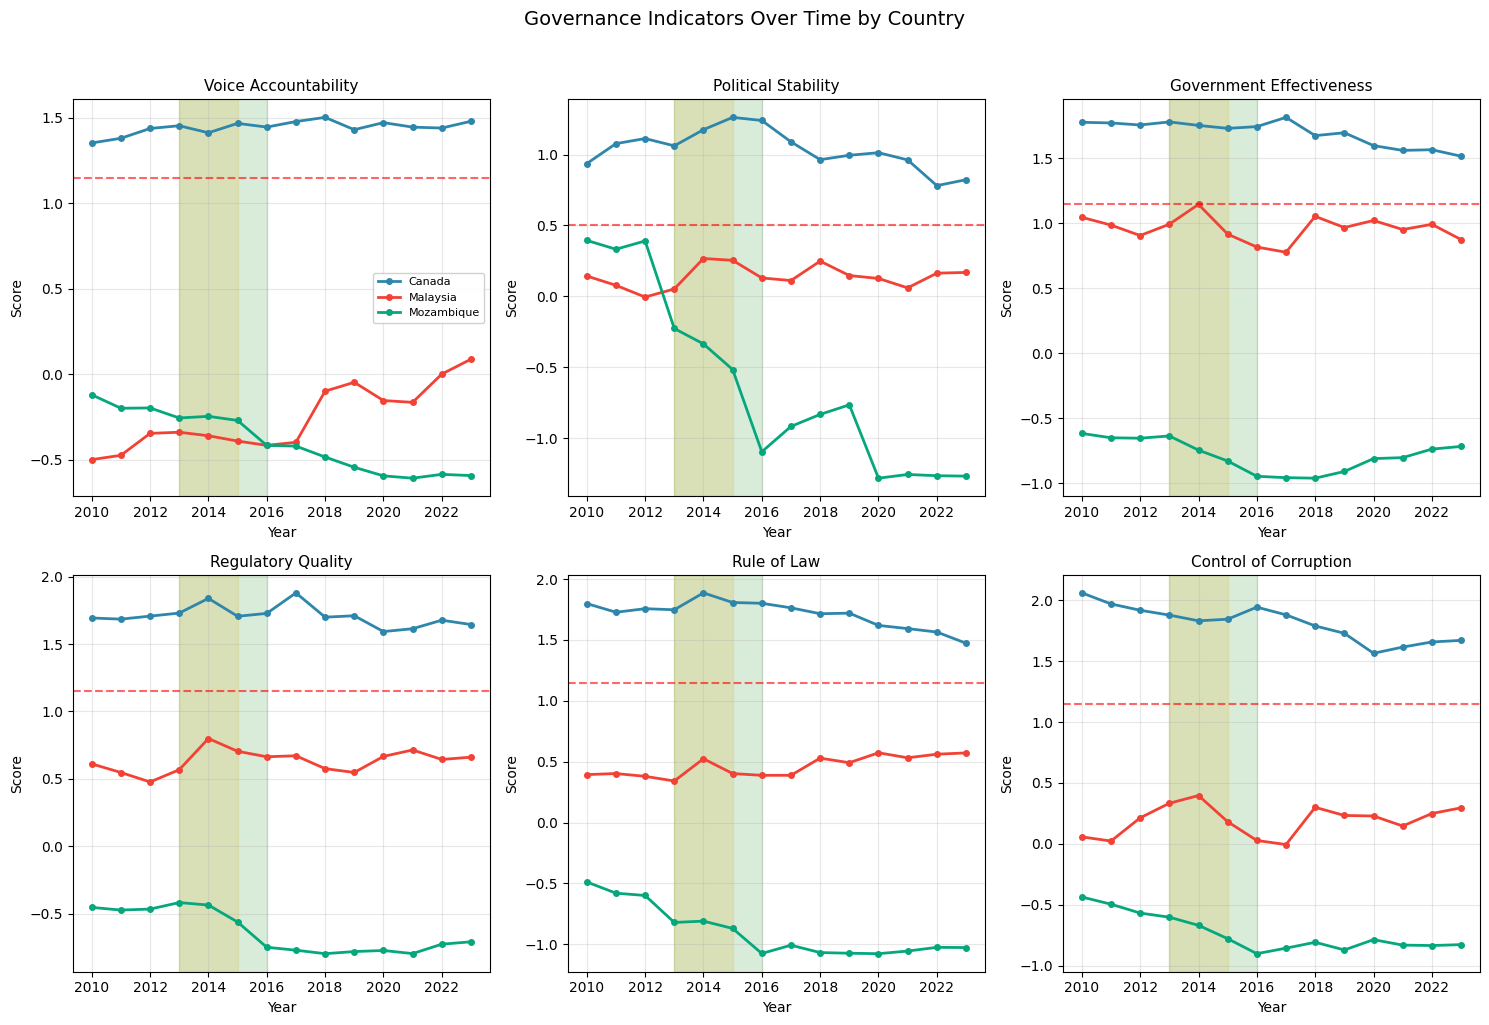

In [31]:
# governance indicators over time with threshold lines
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Governance Indicators Over Time by Country', fontsize=14, y=1.02)

indicators = list(thresholds.keys())
countries = df['Country'].unique()
colors = {'Canada': '#2E86AB', 'Malaysia': '#F24236', 'Mozambique': '#06A77D'}

for idx, indicator in enumerate(indicators):
    ax = axes[idx // 3, idx % 3]
    
    for country in countries:
        country_data = df[df['Country'] == country]
        ax.plot(country_data['Year'], country_data[indicator], 
                marker='o', label=country, color=colors[country], linewidth=2, markersize=4)
    
    threshold = thresholds[indicator]
    ax.axhline(y=threshold, color='red', linestyle='--', alpha=0.6, linewidth=1.5)
    
    # highlight documented corruption periods
    ax.axvspan(2013, 2015, alpha=0.15, color='orange')
    ax.axvspan(2013, 2016, alpha=0.15, color='green')
    
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(indicator.replace('_', ' '), fontsize=11)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.savefig('results/figures/02/governance_indicators_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

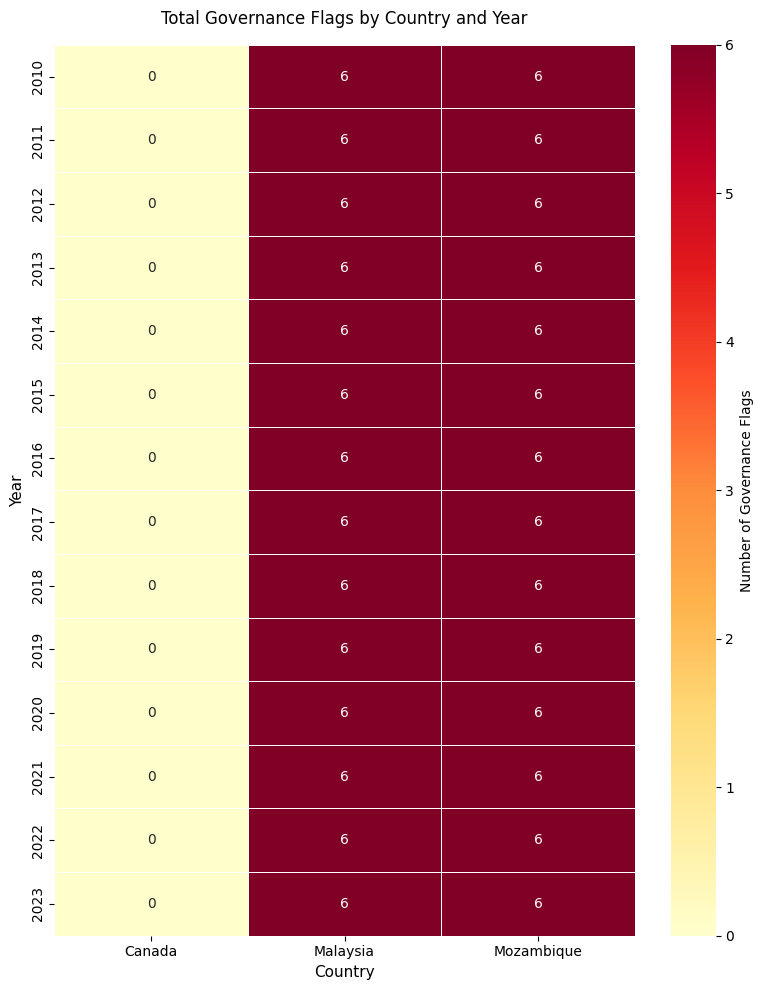

In [32]:
# governance flags heatmap
pivot_flags = df.pivot_table(index='Year', columns='Country', values='total_flags')

plt.figure(figsize=(8, 10))
sns.heatmap(pivot_flags, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Governance Flags'}, linewidths=0.5, 
            square=False, vmin=0, vmax=6)
plt.title('Total Governance Flags by Country and Year', fontsize=12, pad=15)
plt.ylabel('Year', fontsize=11)
plt.xlabel('Country', fontsize=11)
plt.tight_layout()
plt.savefig('results/figures/02/corruption_flags_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

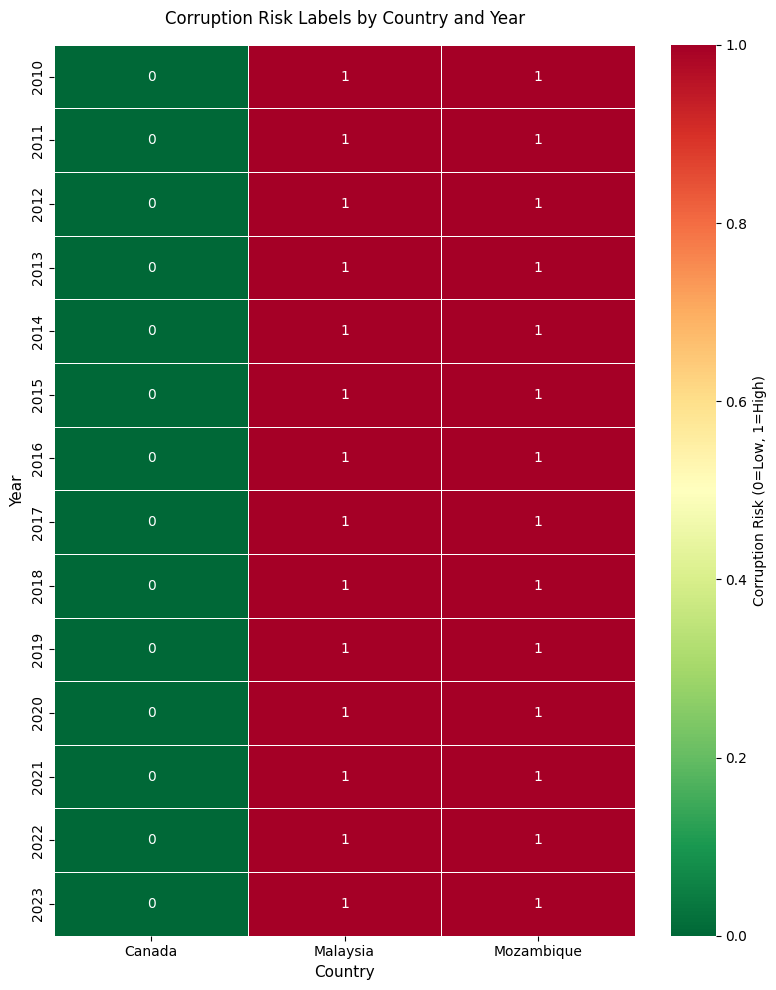

In [33]:
# corruption risk labels heatmap
pivot_risk = df.pivot_table(index='Year', columns='Country', values='corruption_risk')

plt.figure(figsize=(8, 10))
sns.heatmap(pivot_risk, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Corruption Risk (0=Low, 1=High)'}, 
            linewidths=0.5, vmin=0, vmax=1, square=False)
plt.title('Corruption Risk Labels by Country and Year', fontsize=12, pad=15)
plt.ylabel('Year', fontsize=11)
plt.xlabel('Country', fontsize=11)
plt.tight_layout()
plt.savefig('results/figures/02/corruption_risk_labels.png', dpi=300, bbox_inches='tight')
plt.show()

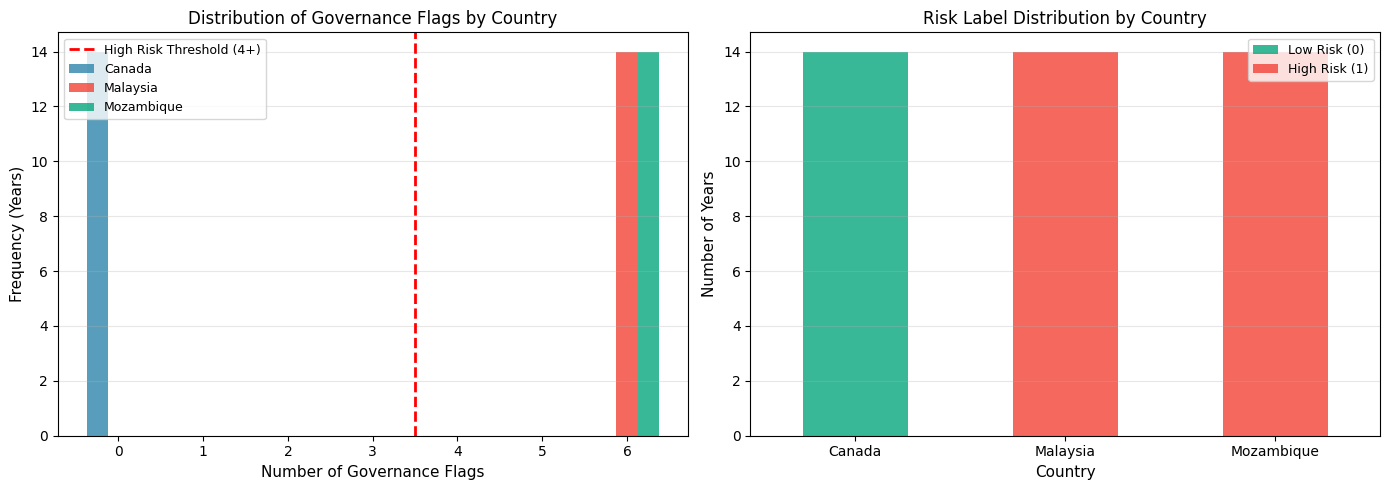

In [34]:
# flag and risk distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# flag distribution by country
flag_values = [0, 1, 2, 3, 4, 5, 6]
canada_counts = [sum(df[df['Country'] == 'Canada']['total_flags'] == i) for i in flag_values]
malaysia_counts = [sum(df[df['Country'] == 'Malaysia']['total_flags'] == i) for i in flag_values]
mozambique_counts = [sum(df[df['Country'] == 'Mozambique']['total_flags'] == i) for i in flag_values]

x_pos = np.arange(len(flag_values))
width = 0.25
axes[0].bar(x_pos - width, canada_counts, width, label='Canada', color='#2E86AB', alpha=0.8)
axes[0].bar(x_pos, malaysia_counts, width, label='Malaysia', color='#F24236', alpha=0.8)
axes[0].bar(x_pos + width, mozambique_counts, width, label='Mozambique', color='#06A77D', alpha=0.8)

axes[0].axvline(x=3.5, color='red', linestyle='--', linewidth=2, label='High Risk Threshold (4+)')
axes[0].set_xlabel('Number of Governance Flags', fontsize=11)
axes[0].set_ylabel('Frequency (Years)', fontsize=11)
axes[0].set_title('Distribution of Governance Flags by Country', fontsize=12)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(flag_values)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')

# risk label distribution
risk_counts = df.groupby('Country')['corruption_risk'].value_counts().unstack(fill_value=0)
risk_counts.plot(kind='bar', stacked=True, ax=axes[1], color=['#06A77D', '#F24236'], alpha=0.8)
axes[1].set_xlabel('Country', fontsize=11)
axes[1].set_ylabel('Number of Years', fontsize=11)
axes[1].set_title('Risk Label Distribution by Country', fontsize=12)
axes[1].legend(['Low Risk (0)', 'High Risk (1)'], fontsize=9)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figures/02/flag_risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Export Processed Dataset

The cleaned and labeled dataset is saved for subsequent model training phases.

In [35]:
output_path = 'data/processed/corruption_data_labeled.csv'
df.to_csv(output_path, index=False)
print(f"Dataset saved: {output_path}")
print(f"Final dimensions: {df.shape[0]} observations × {df.shape[1]} variables")

Dataset saved: data/processed/corruption_data_labeled.csv
Final dimensions: 42 observations × 21 variables


In [36]:
# final summary
print("\nDataset Summary:")
print(f"  Countries: {df['Country'].nunique()}")
print(f"  Time period: {df['Year'].min()}-{df['Year'].max()}")
print(f"  Low risk: {(df['corruption_risk'] == 0).sum()} observations ({(df['corruption_risk'] == 0).mean():.1%})")
print(f"  High risk: {(df['corruption_risk'] == 1).sum()} observations ({(df['corruption_risk'] == 1).mean():.1%})")
print(f"\nValidation Results:")
print(f"  Malaysia 1MDB period correctly labeled: {malaysia_scandal['corruption_risk'].all()}")
print(f"  Mozambique hidden debt period correctly labeled: {mozambique_scandal['corruption_risk'].all()}")


Dataset Summary:
  Countries: 3
  Time period: 2010-2023
  Low risk: 14 observations (33.3%)
  High risk: 28 observations (66.7%)

Validation Results:
  Malaysia 1MDB period correctly labeled: True
  Mozambique hidden debt period correctly labeled: True
